Deep artificial neural network for expressive timing and dynamics predictions in musical pieces
---------------

This notebook loads a sequential dataset with score and performance information and uses it to train and test a deep artificial neural network for generating onset timing deviation and peak loudness level of notes from musical pieces.


#### Preparing to install XLA (for training on TPUs) and pytorch-lightning (skip if not using Google Colab):

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
%%capture
! pip install pytorch_lightning --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Parameters to set:

In [1]:
runLocal = True  # set to False for using Google Colab

class Args:
    pass

### This one set to MusicNet model
args = Args()
args.data = 'MNv_I_train_sequences_fold_0.data'
args.val_data = 'MNv_I_test_sequences.data'
args.model_state = 'Results\\2021-11-23-192-4-len16w8-MNv.pth'
args.eval = True
args.gen_attr = ['ioiRatio', 'durationSecs', 'peakLevel']
args.vocab_size = 92
args.lr = 1e-4
args.seq_len = 16
args.hidden_size = 128
args.dec_layers = 4
args.enc_layers = 4
args.dropout = 0.1
args.batch_size = 128
args.max_steps = 70000
args.scheduler_step = 15000
args.lr_decay_by = 0.5
args.stride = 8
args.context = 4
args.no_ctx_train = False
args.dev_run = False
args.workers = 2
args.cpu_only = False
args.pitch_dict = 'mF_pitch_dict.data'
args.norm = 'MNv_I_normalizer_fold_0.data'
args.test_data = 'MNv_I_test_sequences.data'

In [1]:
runLocal = True  # set to False for using Google Colab

class Args:
    pass

### This one set to Maestro model
args = Args()
args.data = 'mF_train_sequences.data'
args.val_data = 'mF_test_sequences.data'
args.model_state = 'Results\\2021-11-12-sztest-128-44-mF.pth'
args.eval = True
args.gen_attr = ['velocity']
args.vocab_size = 92
args.lr = 3e-4
args.seq_len = 32
args.hidden_size = 128
args.dec_layers = 4
args.enc_layers = 4
args.dropout = 0.04
args.batch_size = 128
args.max_steps = 100000
args.scheduler_step = 15000
args.lr_decay_by = 0.5
args.stride = 16
args.context = 8
args.no_ctx_train = False
args.dev_run = False
args.workers = 2
args.cpu_only = False
args.pitch_dict = 'mF_pitch_dict.data'
args.norm = 'mF_normalizer.data'
args.test_data = 'mF_test_sequences.data'

#### Setting path and loading dataset

In [2]:
import os
import numpy as np
import pandas as pd
import pickle


if runLocal:
    pathRoot = 'C:\\Users\\fabio\\Datasets'
else:
    pathRoot = '/content/drive/My Drive/colab_data/'
    !wget "https://raw.githubusercontent.com/fabiozeh/deep-expression/master/dataloader.py"
    !wget "https://raw.githubusercontent.com/fabiozeh/deep-expression/master/seq2seq.py"

    
with open(os.path.join(pathRoot, args.data), 'rb') as seq_path:
    train = pickle.load(seq_path)
with open(os.path.join(pathRoot, args.val_data), 'rb') as seq_path:
    val = pickle.load(seq_path)

#### Defining the neural network

In [3]:
import pytorch_lightning as pl
import seq2seq

model = seq2seq.Net(train[0][0][0].shape[1],
            len(args.gen_attr),
            vocab_size=args.vocab_size, # len(ix_to_lex) + 4,  # 0 = pad, len+1 = UKN, len+2 = END, len+3 = SOS
            hidden_size=args.hidden_size,
            dropout_rate=args.dropout,
            lr=args.lr,
            context=(0 if args.no_ctx_train else args.context),
            window=(0 if args.no_ctx_train else args.stride),
            scheduler_step=args.scheduler_step,
            lr_decay_by=args.lr_decay_by,
            dec_layers=args.dec_layers,
            enc_layers=args.enc_layers)

## Train the model

In [ ]:
seq2seq.run_with_args(model, train, val, args)

#### Results

In [4]:
import torch

# Load model
model.load_state_dict(torch.load(args.model_state))

model.eval()

Yhat, mse = seq2seq.evaluation(val, args.seq_len, model, stride=args.stride, output_cols=args.gen_attr,
                               context=args.context, pad_both_ends=(not args.no_ctx_train))
    
for i, col in enumerate(args.gen_attr):
    print('Validation set MSE for ' + col + ': ' + str(np.mean(mse[:, i])))
    print('Minimum MSE among pieces for ' + col + ': ' + str(mse[:, i].min()))

Validation set MSE for velocity: 0.528219929300928
Minimum MSE among pieces for velocity: 0.2338694866344312


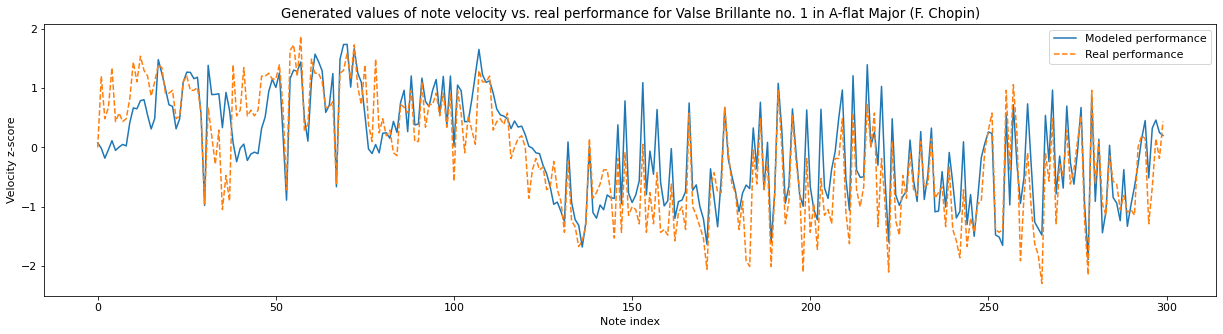

In [20]:
import matplotlib.pyplot as plt
#32 35 0
piece = 57
attr = ['velocity']
plt.figure(figsize=(21, 5))
plt.plot(Yhat[piece][:300,0], label="Modeled performance")
plt.plot(val[piece][0][1].loc[:,attr].to_numpy()[:300], label="Real performance", linestyle="dashed")
plt.title("Generated values of note velocity vs. real performance for Valse Brillante no. 1 in A-flat Major (F. Chopin)")
plt.rcParams.update({"font.size": 11})
plt.xlabel("Note index")
plt.ylabel("Velocity z-score")
plt.legend()
# plt.plot(Y16[piece][:,0])
# print(test_sequences[piece][1].columns[attr])
# plt.savefig("velcomparison.pdf")
plt.show()

In [18]:
val[piece]

((         pitch  onsetDiff  durationSecs
  0           91   0.000000      0.000000
  5356582      1   2.711495     -0.378456
  5356583      1   1.045626     -0.439676
  5356584      1   0.005635     -0.415721
  5356585      1   0.071517     -0.431691
  ...        ...        ...           ...
  5360179     75   6.000880      6.904056
  5360180      8  -0.436714      6.986570
  5360181     69  -0.446126      7.907531
  5360182     30  -0.446126      8.647494
  0           90   0.000000      0.000000
  
  [3603 rows x 3 columns],
           velocity
  0        0.000000
  5356582  1.202067
  5356583  0.484422
  5356584  0.675794
  5356585  1.345596
  ...           ...
  5360179  1.489125
  5360180  1.010695
  5360181  0.771480
  5360182  1.106381
  0        0.000000
  
  [3603 rows x 1 columns],
  array([[65.87475701, 20.90170458]])),
 2015075,
 0)

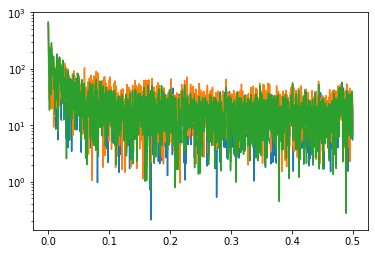

In [117]:
from scipy.fft import fft, fftfreq
from scipy.signal import blackman
from scipy.ndimage.filters import uniform_filter1d

piece = 63
n = len(Yhat[piece][:,0])
w = blackman(n)
yf = fft(Yhat[piece][:,0]*w)
xf = fftfreq(n)[:n//2]

valf = fft(val[piece][0][1].loc[:,attr].to_numpy().flatten()*w)
y16f = fft(Y16[piece][:,0]*w)
plt.semilogy(xf, np.abs(yf[:n//2]))
plt.semilogy(xf, np.abs(valf[:n//2]))
plt.semilogy(xf, np.abs(y16f[:n//2]))
plt.show()
#plt.xlim(right=0.1)

In [115]:
valf.flatten().shape

(4949,)

#### Comparison of dynamics of different performances of same piece for context:

In [ ]:
import matplotlib.pyplot as plt
with open(os.path.join(pathRoot, 'single fold/LvB_train_sequences.data'), 'rb') as seq_path:
    trainsf = pickle.load(seq_path)
attr = 'ioiRatio'
plt.figure(figsize=(21, 5))
plt.plot(trainsf[35][0][1].loc[:,attr].to_numpy()[2500:])
plt.plot(trainsf[70][0][1].loc[:,attr].to_numpy()[2500:])
plt.figure(figsize=(21, 5))
plt.plot(trainsf[42][0][1].loc[:,attr].to_numpy()[1000:1300])
plt.plot(trainsf[77][0][1].loc[:,attr].to_numpy()[1000:1300])

In [ ]:
with open(os.path.join(pathRoot, 'single fold/LvB_train_sequences.data'), 'rb') as seq_path:
    trainsf = pickle.load(seq_path)
attr = 'ioiRatio'
mse_human1 = np.mean((trainsf[70][0][1].loc[:, attr].iloc[:3120].to_numpy('float64') - trainsf[35][0][1].loc[:, attr].iloc[:3120].to_numpy('float64')) ** 2)
mse_human2 = np.mean((trainsf[42][0][1].loc[:, attr].to_numpy('float64') - trainsf[77][0][1].loc[:, attr].to_numpy('float64')) ** 2)

print("MSE between two performances of sonata 7, 2nd mvmt. (has alignment issues): " + str(mse_human1))
print("MSE between two performances of sonata 7, 3rd mvmt.: " + str(mse_human2))

#### Listen to a piece synthesized with the generated expression

In [8]:
import pretty_midi
import IPython.display
import expression_modeling as m

with open(os.path.join(pathRoot, args.pitch_dict), 'rb') as filehandle:
    lex_to_ix = pickle.load(filehandle)
    ix_to_lex = {v: k for k, v in lex_to_ix.items()}
with open(os.path.join(pathRoot, args.norm), 'rb') as filehandle:
    moments, cols = pickle.load(filehandle)
    moments = dict(zip(cols, list(moments)))
with open(os.path.join(pathRoot, args.test_data), 'rb') as seq_path:
    test = pickle.load(seq_path)

# piece to synthesize:
pieceNum = 75
pieceId = val[pieceNum][1]
print(pieceId)

pred = Yhat[pieceNum][:,:2]
ref = val[pieceNum][0][1].velocity

pm = m.midi_performance(val[pieceNum][0], pred, moments, ix_to_lex, method='velocity')
#IPython.display.Audio(pm.fluidsynth(fs=44100), rate=44100)
pm.write(str(pieceId) + '.mid')

2013041


In [13]:
import pretty_midi
import IPython.display
import expression_modeling as m

with open(os.path.join(pathRoot, args.pitch_dict), 'rb') as filehandle:
    lex_to_ix = pickle.load(filehandle)
    ix_to_lex = {v: k for k, v in lex_to_ix.items()}
with open(os.path.join(pathRoot, args.norm), 'rb') as filehandle:
    moments, cols = pickle.load(filehandle)
    moments = dict(zip(cols, list(moments)))
with open(os.path.join(pathRoot, args.test_data), 'rb') as seq_path:
    test = pickle.load(seq_path)

# piece to synthesize:
pieceNum = 7
pieceId = val[pieceNum][1]
print(pieceId)

pred = Yhat[pieceNum][:,:2]
ref = val[pieceNum][0][1].ioiRatio
no_dev = np.asarray([val[pieceNum][0][2][2,0]] * val[pieceNum][0][1].shape[0])
dev_rand = np.random.normal(size=val[pieceNum][0][1].shape[0]) * val[pieceNum][0][2][2,1] + val[pieceNum][0][2][2,0]

pm = m.midi_performance(val[pieceNum][0], pred, moments, ix_to_lex, method='ioiRatio')
#IPython.display.Audio(pm.fluidsynth(fs=44100), rate=44100)
pm.write(str(pieceId) + '.mid')

2140


In [7]:
i = 0
for a in val:
    print(str(i) + '  ' + str(a[1]))
    i += 1

0  2006016
1  2009089
2  2008070
3  2009094
4  2008073
5  2008074
6  2008076
7  2011149
8  2009102
9  2011152
10  2006034
11  2009108
12  2009111
13  2008089
14  2008090
15  2009116
16  2009117
17  2006046
18  2008097
19  2006050
20  2008099
21  2006057
22  2008107
23  2008110
24  2006072
25  2008125
26  2004032
27  2006081
28  2008133
29  2004041
30  2008137
31  2006106
32  2004059
33  2006112
34  2004067
35  2004073
36  2004110
37  2004125
38  2004126
39  2004128
40  2017014
41  2017023
42  2017034
43  2017048
44  2015007
45  2017057
46  2017069
47  2014000
48  2017072
49  2017077
50  2017078
51  2014008
52  2015034
53  2017082
54  2014012
55  2015038
56  2015039
57  2017091
58  2014023
59  2017096
60  2014027
61  2015052
62  2014031
63  2014034
64  2013012
65  2014039
66  2014041
67  2017115
68  2013022
69  2014046
70  2014047
71  2017120
72  2014053
73  2013031
74  2015087
75  2013041
76  2015089
77  2015091
78  2014069
79  2011001
80  2014073
81  2013054
82  2013055
83  2011009
84

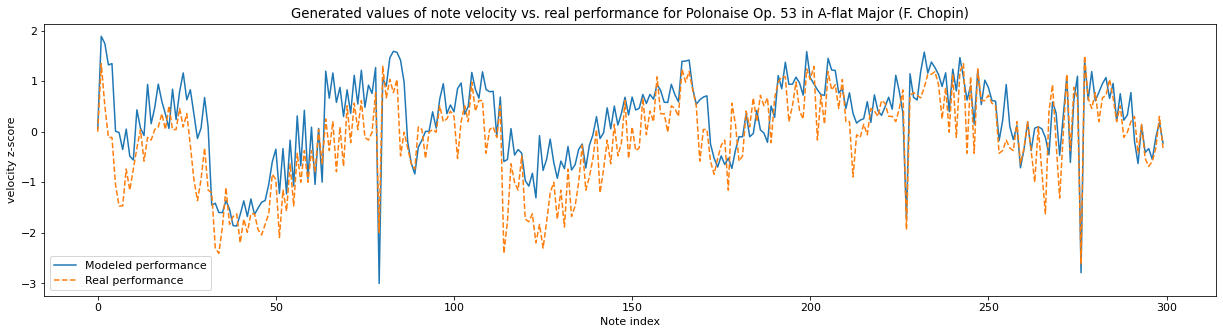

In [14]:
import matplotlib.pyplot as plt
#32 35 0
piece = 75
attr = ['velocity']
plt.figure(figsize=(21, 5))
plt.plot(Yhat[piece][:300,0], label="Modeled performance")
plt.plot(val[piece][0][1].loc[:,attr].to_numpy()[:300], label="Real performance", linestyle="dashed")
plt.title("Generated values of note velocity vs. real performance for Polonaise Op. 53 in A-flat Major (F. Chopin)")
plt.rcParams.update({"font.size": 11})
plt.xlabel("Note index")
plt.ylabel("velocity z-score")
plt.legend()
# plt.plot(Y16[piece][:,0])
# print(test_sequences[piece][1].columns[attr])
plt.savefig("polonaise.pdf")
plt.show()

In [9]:
mse[:, 1]

array([0.44027798, 0.31262542, 0.40047395, 0.35546943, 0.37432768,
       0.26294676, 0.10539296, 0.85438332, 0.39353045, 0.5995871 ,
       0.36876883, 0.34246125])

In [12]:
def midi_performance(test, prediction, moments, ix_to_lex):
    """
    Returns a pretty_midi object with a performance generated according to the
    given numpy array of performance actions. Method specifies which measurement
    of tempo and timing deviations was used.
    """
    pm = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(1, is_drum=False, name='piano')
    pm.instruments.append(piano)
    velocity =  prediction[:, 0] * test[2][0, 1] + test[2][0, 0]
    start = 0.
    for x, v in zip(test[0].itertuples(), velocity):
        pitch = ix_to_lex.get(x.pitch)
        if pitch:
            pitch = pitch[0]
            start += x.onsetDiff * moments['onsetDiff'][1] + moments['onsetDiff'][0]
            end = start + (x.durationSecs * moments['durationSecs'][1] + moments['durationSecs'][0])
            piano.notes.append(pretty_midi.Note(100, pitch, start, end))
    return pm

In [13]:
with open(os.path.join(pathRoot, args.pitch_dict), 'rb') as filehandle:
    lex_to_ix = pickle.load(filehandle)
    ix_to_lex = {v: k for k, v in lex_to_ix.items()}
with open(os.path.join(pathRoot, args.norm), 'rb') as filehandle:
    moments, cols = pickle.load(filehandle)
    moments = dict(zip(cols, list(moments)))

# piece to synthesize:
pieceNum = 75
pieceId = val[pieceNum][1]
print(pieceId)

pred = Yhat[pieceNum][:,:]

pm = midi_performance(val[pieceNum][0], pred, moments, ix_to_lex)
#IPython.display.Audio(pm.fluidsynth(fs=44100), rate=44100)
pm.write(str(pieceId) + '_deadpan.mid')

2013041
